In [1]:
import sys
import os
os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory:", os.getcwd())

from OptimisationScripts.OptimisationModel import OptimModel
from PreOptimisationDataStore.DefaultParameters import Default_Params
from StochasticScripts.WeatherSensitivity import get_weather_sensitivity
import numpy as np
from pandas import read_csv
from os import getcwd, chdir, environ, popen,system
from dill import dump   
print("Gurobi version:", popen('gurobi_cl --version').read())


Current working directory: /Users/cameronaldren/Documents/Git/StochasticOperaitonsModel
Gurobi version: Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[arm] - Darwin 24.0.0 24A348)
Copyright (c) 2023, Gurobi Optimization, LLC



In [2]:
location_data = read_csv('./WeatherModel/WeatherData/Chile_Locations_Coords.csv')
NH3_LCOH_data = read_csv('./DataAnalysis/NH3Chile_Locations.csv')
LH2_LCOH_data = read_csv('./DataAnalysis/LH2Chile_Locations.csv')
NH3_columns = [float(i[:10]) for i in NH3_LCOH_data.columns]
LH2_columns = [float(i[:10]) for i in LH2_LCOH_data.columns]
NH3_LCOH_data.loc[-1] = NH3_columns
NH3_LCOH_data.index = NH3_LCOH_data.index + 1 
NH3_LCOH_data.sort_index(inplace=True)  
NH3_LCOH_data.columns = range(NH3_LCOH_data.shape[1])
LH2_LCOH_data.loc[-1] = LH2_columns
LH2_LCOH_data.index = LH2_LCOH_data.index + 1 
LH2_LCOH_data.sort_index(inplace=True)  
LH2_LCOH_data.columns = range(LH2_LCOH_data.shape[1])

In [3]:
NH3_LCOH_data.iloc[:, 1:]

,1,2,3,4,5,6,7,8,9,10,...,18,19,20,21,22,23,24,25,26,27
0,1.543111,1.548319,1.548294,1.559618,1.557480,1.557006,1.557480,1.557480,1.557480,1.553990,...,1.553973,1.553994,1.554000,1.554029,1.553973,1.553973,1.554080,1.554080,1.553994,1.554030
1,1.757150,1.767873,1.767873,1.860607,1.861667,1.860607,1.860607,1.861667,1.860607,1.735355,...,1.735302,1.735377,1.735793,1.735408,1.735363,1.735343,1.736125,1.735286,1.735338,1.735396
2,3.114992,3.445566,3.445566,3.555848,3.555848,3.556114,3.555848,3.555848,3.556114,3.082419,...,3.082446,3.082391,3.082590,3.082590,3.082414,3.082350,3.082413,3.082508,3.082474,3.082446
3,3.540205,3.875240,3.875240,3.908461,3.908461,3.908461,3.908461,3.908461,3.908461,3.765767,...,3.765767,3.765767,3.765767,3.765767,3.765767,3.765767,3.765767,3.765767,3.765767,3.765767
4,3.502544,3.549410,3.549410,3.646631,3.650503,3.649292,3.651958,3.646873,3.648082,3.678764,...,3.680320,3.677144,3.678989,3.677144,3.679489,3.678751,3.676722,3.676913,3.680603,3.678757
5,2.871778,3.049107,3.049107,3.081716,3.082033,3.082033,3.082033,3.081716,3.081716,3.056300,...,3.056300,3.056300,3.056245,3.056300,3.056245,3.056300,3.056300,3.056300,3.056300,3.056245
6,2.493625,2.523982,2.525547,2.528018,2.528645,2.531552,2.527861,2.530609,2.528096,2.550658,...,2.550658,2.550658,2.550658,2.550658,2.550658,2.550658,2.550658,2.550658,2.550658,2.550658
7,2.488794,2.479859,2.479859,2.480723,2.480723,2.480723,2.480723,2.480723,2.480723,2.492076,...,2.492076,2.492076,2.491314,2.492076,2.491089,2.491314,2.491314,2.492076,2.492076,2.492076
8,2.492376,2.458792,2.457096,2.482913,2.482351,2.482311,2.486051,2.483705,2.486051,2.531023,...,2.528224,2.527425,2.527425,2.527425,2.527425,2.527425,2.527425,2.527425,2.527425,2.527425
9,2.528573,2.536292,2.536608,2.567619,2.567619,2.567577,2.567619,2.567619,2.567253,2.568132,...,2.568089,2.568041,2.568132,2.567807,2.567944,2.567987,2.568089,2.568093,2.568136,2.567807


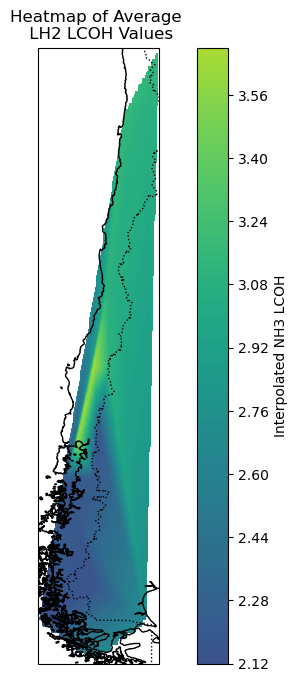

In [4]:
import numpy as np
from scipy.interpolate import griddata

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Calculate the average values of the columns of NH3_LCOH_data
average_values = LH2_LCOH_data.iloc[:, 1:].astype(float).mean(axis=1)

# Create a grid of coordinates from location_data
latitudes = location_data[['lat_0', 'lat_1']].mean(axis=1)
longitudes = location_data[['lon_0', 'lon_1']].mean(axis=1)

# Create a scatter plot on a map
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([location_data['lon_0'].min(), location_data['lon_1'].max(), location_data['lat_0'].min(), location_data['lat_1'].max()], crs=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.COASTLINE)

# Define grid for interpolation
grid_lon = np.linspace(location_data['lon_0'].min(), location_data['lon_1'].max(), 100)
grid_lat = np.linspace(location_data['lat_0'].min(), location_data['lat_1'].max(), 100)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)

zipped_data = (np.array([*zip(location_data['lon_0'],location_data['lon_1'])]).flatten(), np.array([*zip(location_data['lat_0'],location_data['lat_1'])]).flatten()) 
zipped_values = np.array([*zip(average_values,average_values)]).flatten()
# Perform the interpolation
grid_values = griddata(zipped_data,zipped_values, (grid_lon, grid_lat), method='linear')

# Plot the interpolated heatmap
contour = ax.contourf(grid_lon, grid_lat, grid_values, levels=100, cmap='viridis', transform=ccrs.PlateCarree())
plt.colorbar(contour, ax=ax, orientation='vertical', label='Interpolated NH3 LCOH')
contour.set_clim(1.5, 4)

plt.title('Heatmap of Average \n LH2 LCOH Values')
plt.show()
